## TP LeNet5

**LeNet5 est l'un des premiers réseaux de neurones convolutifs (CNN). Il a été proposé par Yann LeCun et d'autres en 1998. Vous pouvez lire l'article original [ici](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) : Gradient-Based Learning Applied to Document Recognition. Dans l'article, le LeNet5 a été utilisé pour la reconnaissance de caractères manuscrits.**

**Comprenons maintenant l'architecture de LeNet5 comme le montre la figure ci-dessous :**

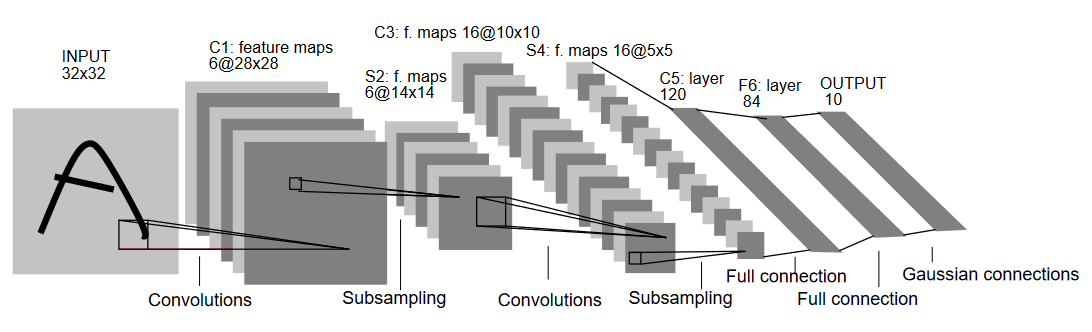

**Comme son nom l'indique, LeNet5 a 5 couches avec deux couches convolutives et trois couches entièrement connectées. Commençons par l'entrée. LeNet5 accepte en entrée une image en niveaux de gris de 32x32, indiquant que l'architecture n'est pas adaptée aux images RVB (canaux multiples). L'image d'entrée ne doit donc contenir qu'un seul canal.**

**La première couche convolutive a une taille de filtre de 5x5 avec 6 de ces filtres. Cela réduira la largeur et la hauteur de l'image tout en augmentant la profondeur (nombre de canaux). La sortie serait 28x28x6. Après cela, la mise en commun est appliquée pour réduire de moitié la carte des fonctionnalités, c'est-à-dire 14x14x6. La même taille de filtre (5x5) avec 16 filtres est maintenant appliquée à la sortie suivie d'une couche de regroupement. Cela réduit la carte des fonctionnalités de sortie à 5x5x16.**

**Après cela, une couche convolutive de taille 5x5 avec 120 filtres est appliquée pour aplatir la carte des caractéristiques à 120 valeurs. Vient ensuite la première couche entièrement connectée, avec 84 neurones. Enfin, nous avons la couche de sortie qui a 10 neurones de sortie, puisque les données MNIST ont 10 classes pour chacun des 10 chiffres numériques représentés.**

## Data Loading
# Dataset

**Commençons par charger et analyser les données. Nous utiliserons le jeu de données MNIST. Le jeu de données MNIST contient des images de chiffres numériques manuscrits. Les images sont en niveaux de gris, toutes d'une taille de 28x28, et sont composées de 60 000 images d'entraînement et de 10 000 images de test.**

**Vous pouvez voir quelques-uns des exemples d'images ci-dessous :**

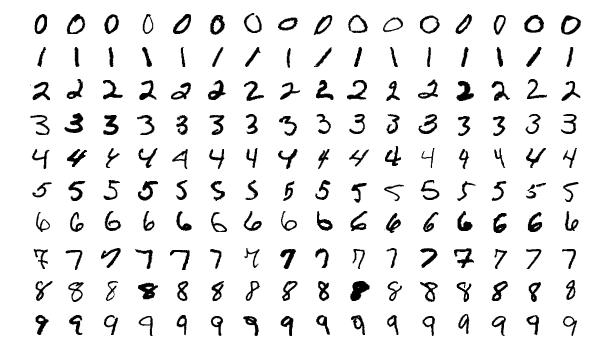

## Importation des librairies

In [19]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Chargement de la dataset

**À l'aide de torchvision , nous chargerons l'ensemble de données car cela nous permettra d'effectuer facilement toutes les étapes de prétraitement.**

In [20]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

Comprenons le code :

- Premièrement, les données MNIST ne peuvent pas être utilisées telles quelles pour l'architecture LeNet5. L'architecture LeNet5 accepte l'entrée en 32x32 et les images MNIST sont en 28x28. Nous pouvons résoudre ce problème en redimensionnant les images, en les normalisant à l'aide de la moyenne et de l'écart type précalculés, et enfin en les stockant sous forme de tenseurs. 


- Nous définissons download=True si les données ne sont pas déjà téléchargées. 


- Ensuite, nous utilisons les dataloader. Les chargeurs de données nous permettent d'itérer les données par lots, et les données sont chargées pendant l'itération et non immédiatement au démarrage. 


- Nous spécifions la taille du lot "batch size" et mélangeons l'ensemble de données lors du chargement afin que chaque lot ait une certaine variation dans les types d'étiquettes dont il dispose. Cela augmentera l'efficacité de notre modèle.

In [21]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

Je vais expliquer le code linéairement:

 - Dans PyTorch, nous définissons un réseau de neurones en créant une classe qui hérite de nn.Module car elle contient de nombreuses méthodes que nous devrons utiliser.
 
 
 - Il y a deux étapes principales après cela. La première consiste à initialiser les couches que nous allons utiliser dans notre CNN à l'intérieur de __init__ , et l'autre consiste à définir la séquence dans laquelle ces couches traiteront l'image. Ceci est défini dans la fonction forward.
 
- Pour l'architecture elle-même, nous définissons d'abord les couches convolutives à l'aide de la fonction nn.Conv2D avec la taille de noyau appropriée et les canaux d'entrée/sortie. Nous appliquons également la mise en commun maximale à l'aide de la fonction nn.MaxPool2D. La bonne chose à propos de PyTorch est que nous pouvons combiner la couche convolutive, la fonction d'activation et la mise en commun maximale en une seule couche (elles seront appliquées séparément, mais cela aide à l'organisation) en utilisant la fonction nn.Sequential.


- Ensuite, nous définissons les couches entièrement connectées. Notez que nous pouvons également utiliser nn.Sequential ici et combiner les fonctions d'activation et les couches linéaires, mais je voulais montrer que l'une ou l'autre est possible.


- Enfin, notre dernière couche produit 10 neurones qui sont nos prédictions finales pour les chiffres.

## Définition des hyperparamètres


**Avant la formation, nous devons définir certains hyperparamètres, tels que la fonction de perte et l'optimiseur à utiliser.**

In [22]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)


**Nous commençons par initialiser notre modèle en utilisant le nombre de classes comme argument, qui dans ce cas est 10. Ensuite, nous définissons notre fonction de coût comme perte d'entropie croisée et optimiseur comme Adam. Il y a beaucoup de choix pour ceux-ci, mais ceux-ci ont tendance à donner de bons résultats avec le modèle et les données fournies. Enfin, nous définissons total_step pour mieux suivre les étapes lors de l'entraînement.**

In [23]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [400/938], Loss: 0.0701
Epoch [1/10], Step [800/938], Loss: 0.0676
Epoch [2/10], Step [400/938], Loss: 0.0101
Epoch [2/10], Step [800/938], Loss: 0.0171
Epoch [3/10], Step [400/938], Loss: 0.0190
Epoch [3/10], Step [800/938], Loss: 0.0163
Epoch [4/10], Step [400/938], Loss: 0.0049
Epoch [4/10], Step [800/938], Loss: 0.0100
Epoch [5/10], Step [400/938], Loss: 0.0137
Epoch [5/10], Step [800/938], Loss: 0.0313
Epoch [6/10], Step [400/938], Loss: 0.0240
Epoch [6/10], Step [800/938], Loss: 0.0419
Epoch [7/10], Step [400/938], Loss: 0.0014
Epoch [7/10], Step [800/938], Loss: 0.1592
Epoch [8/10], Step [400/938], Loss: 0.0058
Epoch [8/10], Step [800/938], Loss: 0.0295
Epoch [9/10], Step [400/938], Loss: 0.0016
Epoch [9/10], Step [800/938], Loss: 0.0016
Epoch [10/10], Step [400/938], Loss: 0.0214
Epoch [10/10], Step [800/938], Loss: 0.0027


**Voyons ce que fait le code :**

- Nous commençons par parcourir le nombre d'époques, puis les lots (batch) dans nos données d'apprentissage.


- Nous mettons les images et les étiquettes sur le GPU.


- Dans le forward, nous faisons des prédictions à l'aide de notre modèle et calculons la perte en fonction de ces prédictions et de nos étiquettes réelles.


- Ensuite, nous effectuons le backward où nous mettons à jour nos poids pour améliorer notre modèle


- Nous mettons ensuite les gradients à zéro avant chaque mise à jour à l'aide de la fonction optimiser.zero_grad().


 - Ensuite, nous calculons les nouveaux gradients à l'aide de la fonction loss.backward().


- Et enfin, nous mettons à jour les poids avec la fonction optimiser.step().

**Comme nous pouvons le voir, la perte diminue à chaque époque, ce qui montre que notre modèle apprend effectivement. Notez que cette perte est sur l'ensemble d'entraînement, et si la perte est trop faible (comme c'est le cas dans notre cas), cela peut indiquer un sur-apprentissage.**

In [24]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
	 

Accuracy of the network on the 10000 test images: 98.78 %


## Travail futur 1

Bien que cela semble une très bonne introduction à l'apprentissage en profondeur dans PyTorch, vous devez étendre ce travail :

- Vous pouvez essayer d'utiliser différents ensembles de données, mais pour ce modèle, vous aurez besoin d'ensembles de données en niveaux de gris. L'un de ces ensembles de données est FashionMNIST.


- Vous pouvez expérimenter différents hyperparamètres et voir la meilleure combinaison d'entre eux pour le modèle.


- Vous pouvez essayer d'ajouter ou de supprimer des couches du jeu de données pour voir leur impact sur la capacité du modèle. 


- Enfin vous pouvez également utilisé le [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) pour régulariser le model afin d'éviter le sur apprentissage.



## Travail futur 2

Le travail 2 consiste à implémenter une nouvelle architecture tel que [Resnet](https://pytorch.org/hub/pytorch_vision_resnet/) ou [AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/), pour cela vous devez m'expliquer tous les points suivant:

- L'architecture utilisée sous forme de schéma avec quelque explication ainsi que le lien du papier dans lequel elle a été publié (vous pouvez suivre la même organisation que le Tp).


- La Dataset que vous utiliser ainsi que les différentes transformations appliquées.


-  Les hyperparamètres utilisées.


- M'expliquer comment vous avez évalué votre méthode (test dataset).


## Consigne rendue et notation

- Vous devez répondre à tous les points demandés, si un point n'est pas traité alors il y aura une pénalité sur la note.


- Le code rendu doit être claire et bien commenté. 


- Vous pouvez utiliser du code déjà implémenter mais vous devez me donner le lien du ghit/biblio. et bien commenter son code. Tout plagia sans citation entrainera un zéro.


- Le travail rendu en retard entrainera des penalties de 1 point par jour de retard.


- Vous devez répondre à tous les points demandés, si un point n'est pas traité alors il y aura une pénalité sur la note.



- Le code rendu doit être clair et bien commenté. 


- Vous pouvez utiliser du code déjà implémenter mais vous devez me donner le lien du ghit/biblio. et bien commenter son code. Tout plagia sans citation entrainera un zéro.


-  Le travail rendu en retard entrainera des penaltiés de 1 point par jour de retard.
